## Create PLY File

In [4]:
import numpy
vertex = numpy.array([(0, 0),
                      (0, 1),
                      (1, 1),
                      (1, 0),
                      (2, 1),
                      (2, 0)],
                      dtype=[('x', 'f4'), ('y', 'f4')])

face = numpy.array([([0, 1, 2, 3], 255, 255, 255),
                    ([3, 2, 4, 5], 0, 255, 255)],
                    dtype=[('vertex_indices', 'i4', (4,)),
                           ('red', 'u1'), ('green', 'u1'),
                           ('blue', 'u1')])

In [5]:
from plyfile import PlyData, PlyElement
v = PlyElement.describe(vertex, 'vertex_list')
f = PlyElement.describe(face, 'face_list')
PlyData([v, f], text = True).write('two_square_2d.ply')

## Read  PLY File

In [6]:
plydata = PlyData.read('two_square_2d.ply')

In [7]:
plydata.elements[0].data[0][0] - 1

-1.0

In [8]:
plydata.elements[1].data

array([(array([0, 1, 2, 3]), 255, 255, 255),
       (array([3, 2, 4, 5]),   0, 255, 255)],
      dtype=[('vertex_indices', 'O'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])

## DCEL

In [47]:
from math import acos
from math import sqrt
from math import pi

def length(v):
    return sqrt(v[0]**2+v[1]**2)
def dot_product(v,w):
    return v[0]*w[0]+v[1]*w[1]
def determinant(v,w):
    return v[0]*w[1]-v[1]*w[0]
def inner_angle(v,w):
    cosx=dot_product(v,w)/(length(v)*length(w))
    rad=acos(cosx) # in radians
    return rad*180/pi # returns degrees
def angle_counterclockwise(A, B):
    inner=inner_angle(A,B)
    det = determinant(A,B)
    if det<0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return 360-inner
    else: # if the det > 0 then A is immediately clockwise of B
        return inner

In [144]:
class Vertex():
    def __init__(self, coordinate = [0, 0], color = None):
        self.x = coordinate[0]
        self.y = coordinate[1]
        self.coordinate = np.array([int(self.x), int(self.y)])
    
    def set_incidence_edge(self, halfedge):
        self.incidence_edge = halfedge
        
    def __repr__(self):
        return str(self.coordinate)
        
class Face():
    def __init__(self, outer_component = None, name = None):
        self.outer_component = outer_component
        self.inner_component = []
        self.name = name
        
    def add_inner_component(self, halfedge):
        self.inner_component.append(halfedge)
        
class HalfEdge():
    def __init__(self, origin, has_twin = False):
        self.origin = origin
        self.has_twin = has_twin
        self.twin = None
        self.next = None
        self.prev = None
        
    def __repr__(self):
        return ('HalfEdge{O=' + str(self.origin) + ', D=' + (str(self.next.origin) if self.next is not None else 'none')) + '}'
        
    def set_incidence_face(self, incidence_face):
        self.incidence_face = incidence_face
        
    def set_twin(self, twin_edge):
        self.twin = twin_edge
        self.has_twin = True
        
    def set_next(self, next_edge):
        self.next = next_edge
        
    def set_prev(self, prev_edge):
        self.prev = prev_edge
    

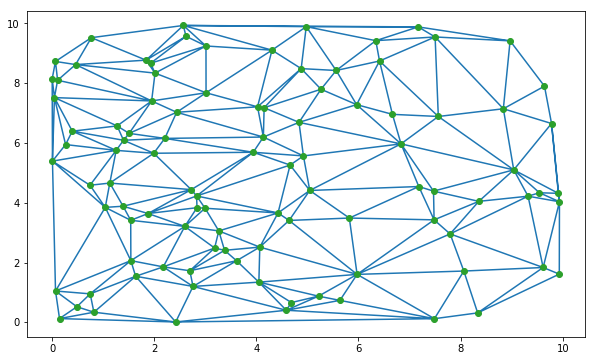

HalfEdge{O=[9 4], D=[9 6]}
Populating the interactive namespace from numpy and matplotlib


C:\Users\tungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\tungu\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['tri']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


LinAlgError: Singular matrix

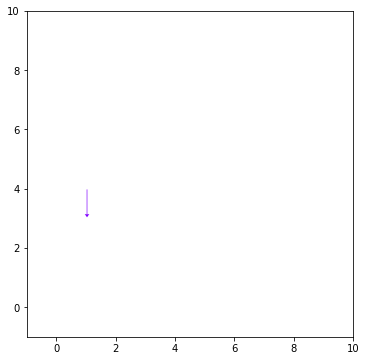

In [219]:
import numpy as np
import matplotlib.cm as cm
class DCEL():
    def __init__(self):
        self.vertices = []
        self.faces = []
        self.halfedges = []
        
    def __construct_bounded_face__(self, triangulation):
        for coordinate in triangulation.points:
            vertex = Vertex(coordinate)
            self.vertices.append(vertex)
            
        for face in triangulation.simplices:
            # create edge list constructing a face
            edges = []
            half_edges = []
            for i in range(len(face)):
                if i < len(face)-1:
                    edges.append((face[i], face[i+1]))
                else:
                    edges.append((face[i], face[0]))

            for edge in edges:
                half_edge = HalfEdge(self.vertices[edge[0]])
                self.vertices[edge[0]].set_incidence_edge(half_edge)
                half_edges.append(half_edge)
                
            face = Face(half_edges[0])
            self.faces.append(face)
            
            # set next and prev pointer of half-edges in half_edges
            for i in range(len(half_edges)):
                
                if i == 0:
                    half_edges[i].set_next(half_edges[i+1])
                    half_edges[i].set_prev(half_edges[-1])
                    half_edges[i].set_incidence_face(face)
                elif i == len(half_edges)-1:
                    half_edges[i].set_next(half_edges[0])
                    half_edges[i].set_prev(half_edges[i-1])
                    half_edges[i].set_incidence_face(face)
                else:
                    half_edges[i].set_next(half_edges[i+1])
                    half_edges[i].set_prev(half_edges[i-1])
                    half_edges[i].set_incidence_face(face)
                    
            for hf in half_edges:
                self.halfedges.append(hf)
            
    def __construct_twin__(self, triangulation):
        self.__construct_bounded_face__(triangulation)
        #Sequentially pick half edge a from half_edge list, check if there exist another half b edge that has its end is a's origin
        #and it's origin is a's end, set a and b are twin of each other.
        for i in range(len(self.halfedges)):
            a = self.halfedges[i]
            if a.has_twin:
                continue
            a_origin = a.origin
            a_end = a.next.origin
            for hf in self.halfedges[i+1:]:
                b_origin = hf.origin
                b_end = hf.next.origin
                if a_origin == b_end and a_end == b_origin:
                    b = hf
                    a.set_twin(b)
                    b.set_twin(a)
                    break
                    
    def __construct_unbounded_face__(self, triangulation):
        self.__construct_twin__(triangulation)
        # for every hafl edge that doesnt have twin edge, find its next by searching for a half edge whose end is its origin
        # and also doesn't have a twin.
        unbounded_face = Face()
        
        without_twin_list = []
        for hf in self.halfedges:
            if not hf.has_twin:
                without_twin_list.append(hf)

        while len(without_twin_list) != 0:
            starting_hf = without_twin_list[0] #take a arbitrary half edge
            end = starting_hf.next.origin
            origin = starting_hf.origin
            print(starting_hf)

            
            starting_twin_hf = HalfEdge(end)
            starting_twin_hf.set_twin(starting_hf)
            starting_hf.set_twin(starting_twin_hf)
            
            current_twin_edge = starting_twin_hf
            self.halfedges.append(starting_twin_hf)
            rm_list = [starting_hf]
            
            while current_twin_edge.next is None:
                candidates = []
                for hf in without_twin_list:
                    end_hf = hf.next.origin
                    if end_hf == origin and not hf.has_twin:
                        candidates.append(hf)
                
                if candidates == []:
                    break
                        
                v1 = end.coordinate - origin.coordinate
                angles = []
                for c in candidates:
                    v2 = c.origin.coordinate - c.next.origin.coordinate
                    counterclockwise_angle = angle_counterclockwise(v1, v2)
                    angles.append(counterclockwise_angle)
                
                index = angles.index(max(angles))
                winner = candidates[index] #^^#
                
                twin_winner = HalfEdge(origin)
                twin_winner.set_twin(winner)
                winner.set_twin(twin_winner)
                
                current_twin_edge.set_next(twin_winner)
                twin_winner.set_prev(current_twin_edge)
                
                current_twin_edge = twin_winner
                rm_list.append(winner)
                origin = winner.origin
                end = winner.next.origin
                self.halfedges.append(twin_winner)
            
            starting_twin_hf = starting_hf.twin
            current_twin_edge.set_next(starting_twin_hf)
            starting_twin_hf.set_prev(current_twin_edge)

            unbounded_face.add_inner_component(rm_list[0])
            for hf in rm_list:
                without_twin_list.remove(hf)
            
            
        self.faces.append(unbounded_face)
                        
    def plot_dcel(self, ax=None):
        if ax is not None:
            splt = ax
        else:
            splt = plt.subplot()
        def detect_cycle():
            cycles = []
            he_set = set(self.halfedges)
            while len(he_set) != 0:
                first_he = he_set.pop()
                current_cycle = [first_he]
                current_he = first_he
                while current_he.next != first_he:
                    current_he = current_he.next
                    he_set.remove(current_he)
                    current_cycle.append(current_he)
                cycles.append(current_cycle)
            return cycles

        def shift_left_he(halfedge):
            x1, y1 = halfedge.origin.coordinate
            x2, y2 = halfedge.next.origin.coordinate
            v = np.array([x2-x1, y2-y1])
            xv, yv = v
            norm = np.linalg.norm([xv, yv])
            a = np.array([[xv, yv], [-yv, xv]])
            b = [0, 0.03*norm]
            dx, dy = np.linalg.solve(a,b)
            dxv, dyv = v/norm*0.03
            return x1+dx+dxv, y1+dy+dyv, x2-x1-2*dxv, y2-y1-2*dyv
        cycles = detect_cycle()
        #splt.set_aspect('equal', 'datalim')
        splt.set_aspect('equal',adjustable='box')
        splt.set_xlim(min([p.coordinate[0] for p in self.vertices]) - 1, max([p.coordinate[0] for p in self.vertices]) + 1)
        splt.set_ylim(min([p.coordinate[1] for p in self.vertices]) - 1, max([p.coordinate[1] for p in self.vertices]) + 1)
        color = iter(cm.rainbow(np.linspace(0,1,len(cycles))))
        he_list = set(self.halfedges)
        for cycle in cycles:
            c = next(color)
            for he in cycle:
                splt.quiver(*shift_left_he(he), scale=1, scale_units='xy', angles='xy', color=c, width=0.002, headwidth=7)
        for face in self.faces:
            if face.outer_component is not None and face.name is not None:
                first_he = face.outer_component
                current_he = face.outer_component
                list_he = [face.outer_component]
                while current_he.next != first_he:
                    current_he = current_he.next
                    list_he.append(current_he)
                x_max = max([he.origin.coordinate[0] for he in list_he])
                x_min = min([he.origin.coordinate[0] for he in list_he])
                y_max = max([he.origin.coordinate[1] for he in list_he])
                y_min = min([he.origin.coordinate[1] for he in list_he])
                cx = (x_max+x_min)/2
                cy = (y_max+y_min)/2
                splt.annotate(face.name, (cx, cy), color='black', weight='bold', 
                    fontsize=6, ha='center', va='center')
            elif face.name is not None:
                splt.set_title('Outer face: ' + face.name)
        if ax is None:
            plt.show()
            
    def construct_from_triangulation(self, triangulation):
        self.__construct_unbounded_face__(triangulation)
        
points = np.random.rand(100, 2) * 10
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

la = DCEL()
la.construct_from_triangulation(tri)

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
la.plot_dcel()

## Generate Random Plannar Graph

In [194]:
import numpy as np
points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

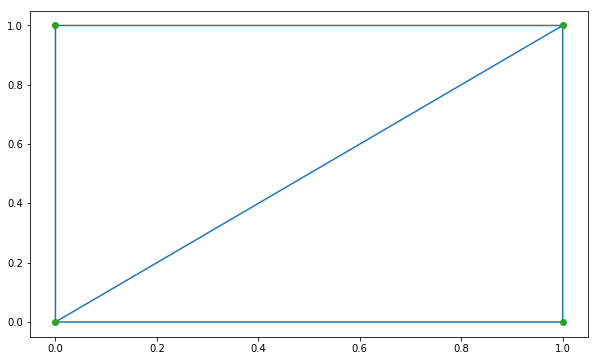

In [195]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [196]:
tri.simplices

array([[3, 1, 0],
       [2, 3, 0]], dtype=int32)

In [197]:
la = DCEL()

In [198]:
la.construct_from_triangulation(tri)

[HalfEdge{O=[1 1], D=[0 1]}, HalfEdge{O=[0 1], D=[0 0]}, HalfEdge{O=[1 0], D=[1 1]}, HalfEdge{O=[0 0], D=[1 0]}]
done
done
done


In [189]:
la.halfedges

[HalfEdge{O=[1 1], D=[0 1]},
 HalfEdge{O=[0 1], D=[0 0]},
 HalfEdge{O=[0 0], D=[1 1]},
 HalfEdge{O=[1 0], D=[1 1]},
 HalfEdge{O=[1 1], D=[0 0]},
 HalfEdge{O=[0 0], D=[1 0]},
 HalfEdge{O=[0 1], D=[1 1]},
 HalfEdge{O=[1 1], D=[1 0]},
 HalfEdge{O=[1 0], D=[0 0]},
 HalfEdge{O=[0 0], D=[0 1]}]

Populating the interactive namespace from numpy and matplotlib


C:\Users\tungu\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['tri']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


KeyError: HalfEdge{O=[0 1], D=[0 0]}

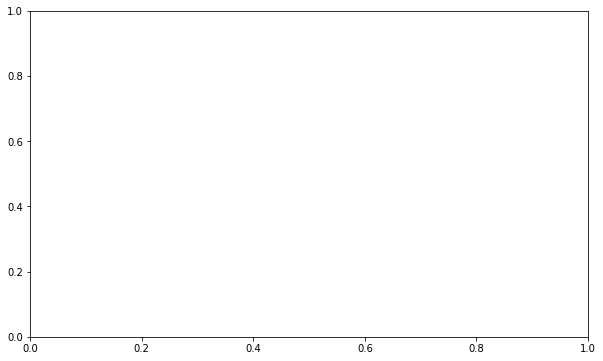

In [199]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
la.plot_dcel()